In [ ]:
import sys
import os

sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks/Simplifying Model/withoutHT')

# Import your module or file
import functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime as dt, timedelta

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import FunctionTransformer

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import statsmodels.api as sm
!pip install shap
import shap

sns_c = sns.color_palette(palette='deep')


In [ ]:
f = '/content/drive/MyDrive/Colab Notebooks/Simplifying Model/reduceddata.csv'
df = pd.read_csv(f)
df.head(5)

,datetime,SR_Level,year,month,day,hour_of_day,day_of_week,Temperature,isholiday,Heat_Demand,Area(m2)
0,2017-01-01 00:00:00,0.0,2017,1,1,0,6,-4.9,1,0.025685,197.0
1,2017-01-01 01:00:00,0.0,2017,1,1,1,6,-5.7,1,0.027897,197.0
2,2017-01-01 02:00:00,0.0,2017,1,1,2,6,-5.7,1,0.027897,197.0
3,2017-01-01 03:00:00,0.0,2017,1,1,3,6,-5.7,1,0.027990,197.0
4,2017-01-01 04:00:00,0.0,2017,1,1,4,6,-5.6,1,0.027614,197.0


In [ ]:
#function to evaluate models
r2 = []
rmses = []
name = []
maes=[]
mapes=[]

def eval(model,y_test, y_pred, m_name):
  mse = mean_squared_error(y_test, y_pred)
  rmse = mean_squared_error(y_test, y_pred,squared=False)
  r_test = metrics.r2_score(y_test, y_pred)
#  r_train = metrics.r2_score(y_train, y_pred_train)
  mae = mean_absolute_error(y_test, y_pred)
  mape = mean_absolute_percentage_error(y_test, y_pred)

  r2.append(r_test)
  rmses.append(rmse)
  maes.append(mae)
  name.append(m_name)
  mapes.append(mape)

In [ ]:
#define pipelines for regression (with and without scaling)


pipe_dt=Pipeline(steps=[('dt',DecisionTreeRegressor())])

pipe_dt_sc=Pipeline(steps=[('sc2',StandardScaler()),
                     ('dtsc',DecisionTreeRegressor())])


allcols=functions.createdflags(df,1)                                       #create df acc to lags
X_test, y_test, X_train, y_train = functions.splitdataseason(allcols,False)      #split data in train-test monthwise (Jan-Sept/Oct-Dec)
temp= X_test['Temperature']
testmonths=X_test.index


In [ ]:
shap.initjs()

In [ ]:
pipe_dt.fit(X_train, y_train)
y_pred_dt=pipe_dt.predict(X_test)
eval(pipe_dt,y_test,y_pred_dt, 'DecisionTreeRegressor with 1 lags')

pipe_dt_sc.fit(X_train, y_train)
y_pred_dt_sc=pipe_dt_sc.predict(X_test)
eval(pipe_dt_sc,y_test,y_pred_dt_sc,'DecisionTreeRegressorScaled with 1 lags')


In [ ]:
# shap.summary_plot function with plot_type=”bar” let you produce the variable importance plot. 
#A variable importance plot lists the most significant variables in descending order.
#The top variables contribute more to the model than the bottom ones and thus have high predictive power.

explainer_dt = shap.TreeExplainer(model=pipe_dt.named_steps['dt'])
shap_values_dt = explainer_dt.shap_values(X_train)

Decision Tree

Variable Importance (Summary) Plot - Global Interpretability

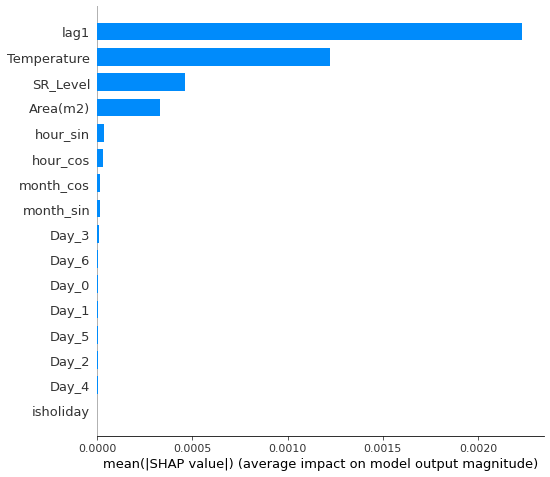

In [ ]:
shap.summary_plot(shap_values_dt, X_train, plot_type="bar")

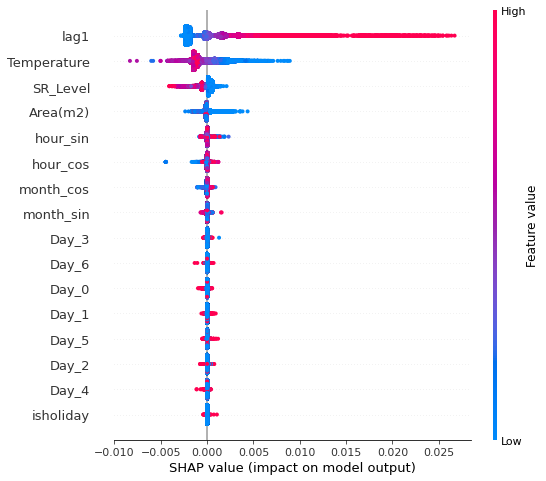

In [ ]:
#The SHAP value plot can further show the positive and negative relationships of the predictors with the target variable.
shap.summary_plot(shap_values_dt, X_train)

SHAP Dependence Plot — Global Interpretability

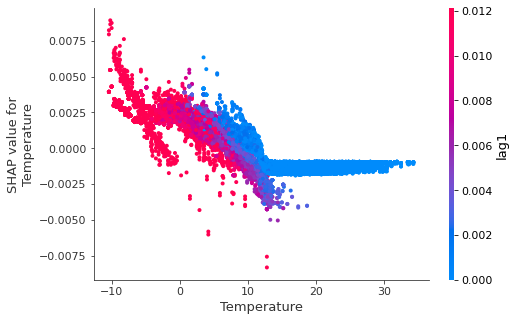

In [ ]:
shap.dependence_plot('Temperature', shap_values_dt, X_train)

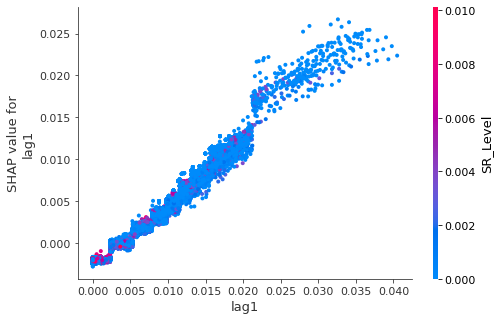

In [ ]:
shap.dependence_plot('lag1', shap_values_dt, X_train)

 Individual SHAP Value (Force) Plot — Local Interpretability

In [ ]:
shap.initjs()

shap.force_plot(explainer_dt.expected_value, shap_values_dt[10], X_train.iloc[[10]])


'\ni=100\nshap.force_plot(explainer.expected_value, shap_values[i,:], X_train.iloc[i,:])\n# i: id of the individual record'

In [ ]:
# Get the predictions and put them with the test data.
X_output_dt = X_test.copy()
X_output_dt.loc[:,'predict'] = np.round(pipe_dt.named_steps['dt'].predict(X_output_dt),2)

# Randomly pick some observations
random_picks_dt = np.arange(1,330,50) # Every 50 rows
S_dt = X_output_dt.iloc[random_picks_dt]
S_dt

# Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()

# Write in a function
def shap_plot_dt(j):
    explainerModel = shap.TreeExplainer(pipe_dt.named_steps['dt'])
    shap_values_Model = explainerModel.shap_values(S_dt)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S_dt.iloc[[j]])
    return(p)

shap_plot_dt(0)

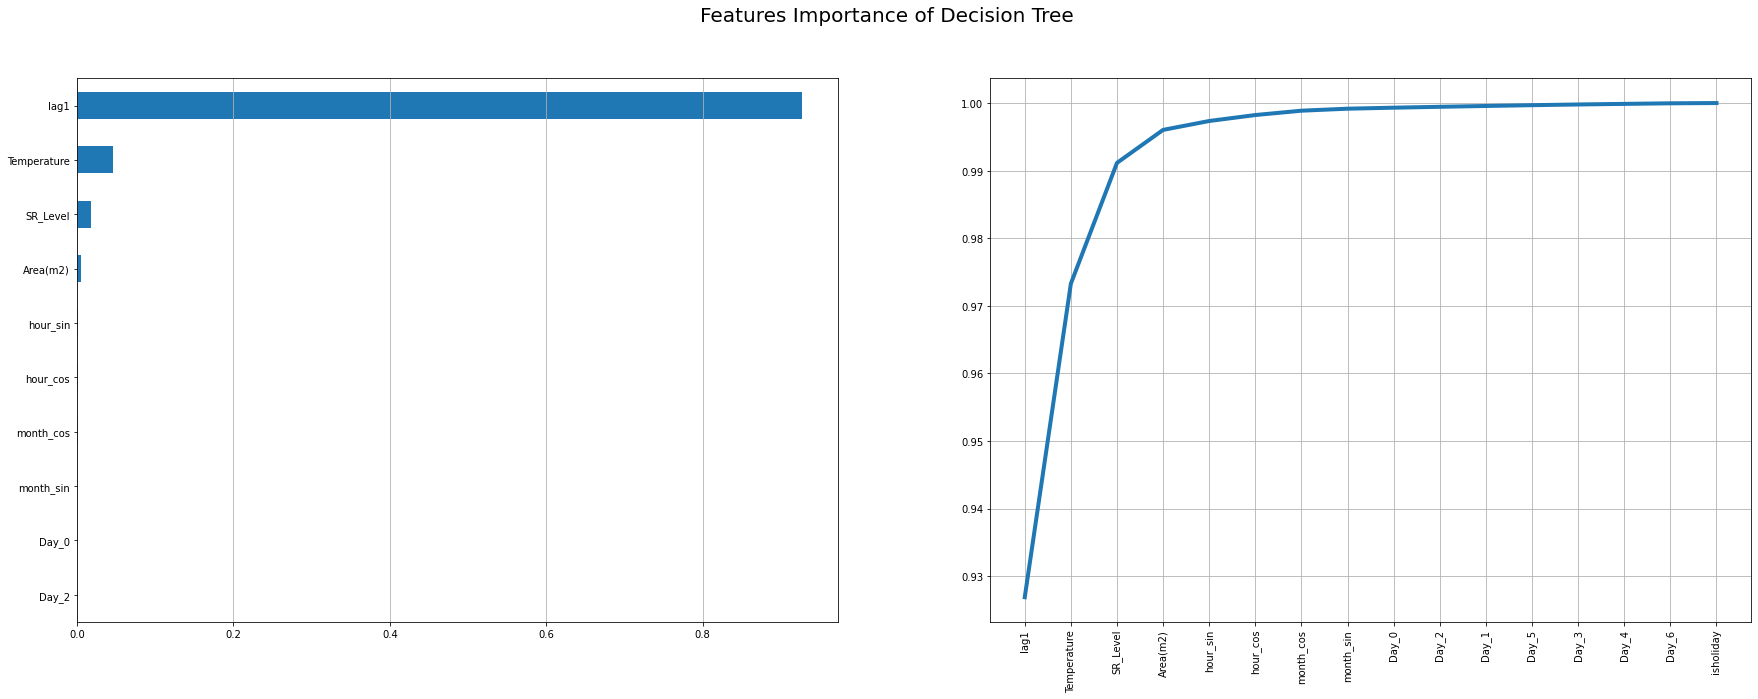

In [ ]:
#Visualizing the Decision Tree Attributes - tree, feature importance, graphs

importances = pipe_dt.named_steps['dt'].feature_importances_
## Put in a pandas dtf
dtf_importances = pd.DataFrame({"IMPORTANCE":importances, 
            "VARIABLE":X_train.columns}).sort_values("IMPORTANCE", 
            ascending=False)
dtf_importances['cumsum'] = dtf_importances['IMPORTANCE'].cumsum(axis=0)
dtf_importances = dtf_importances.set_index("VARIABLE")

## Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False,figsize=(30,10))
fig.suptitle("Features Importance of Decision Tree", fontsize=20)
#ax[0].title.set_text('variables')
dtf_importances[["IMPORTANCE"]].head(10).sort_values(by="IMPORTANCE").plot( kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
#ax[1].title.set_text('cumulative')
dtf_importances[["cumsum"]].plot(kind="line", linewidth=4,legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)),xticklabels=dtf_importances.index)
plt.xticks(rotation=90)
plt.grid(axis='both')
plt.show()


#print('Intercept:',pipe_dt.named_steps['decisiontree'].feature_importances_)


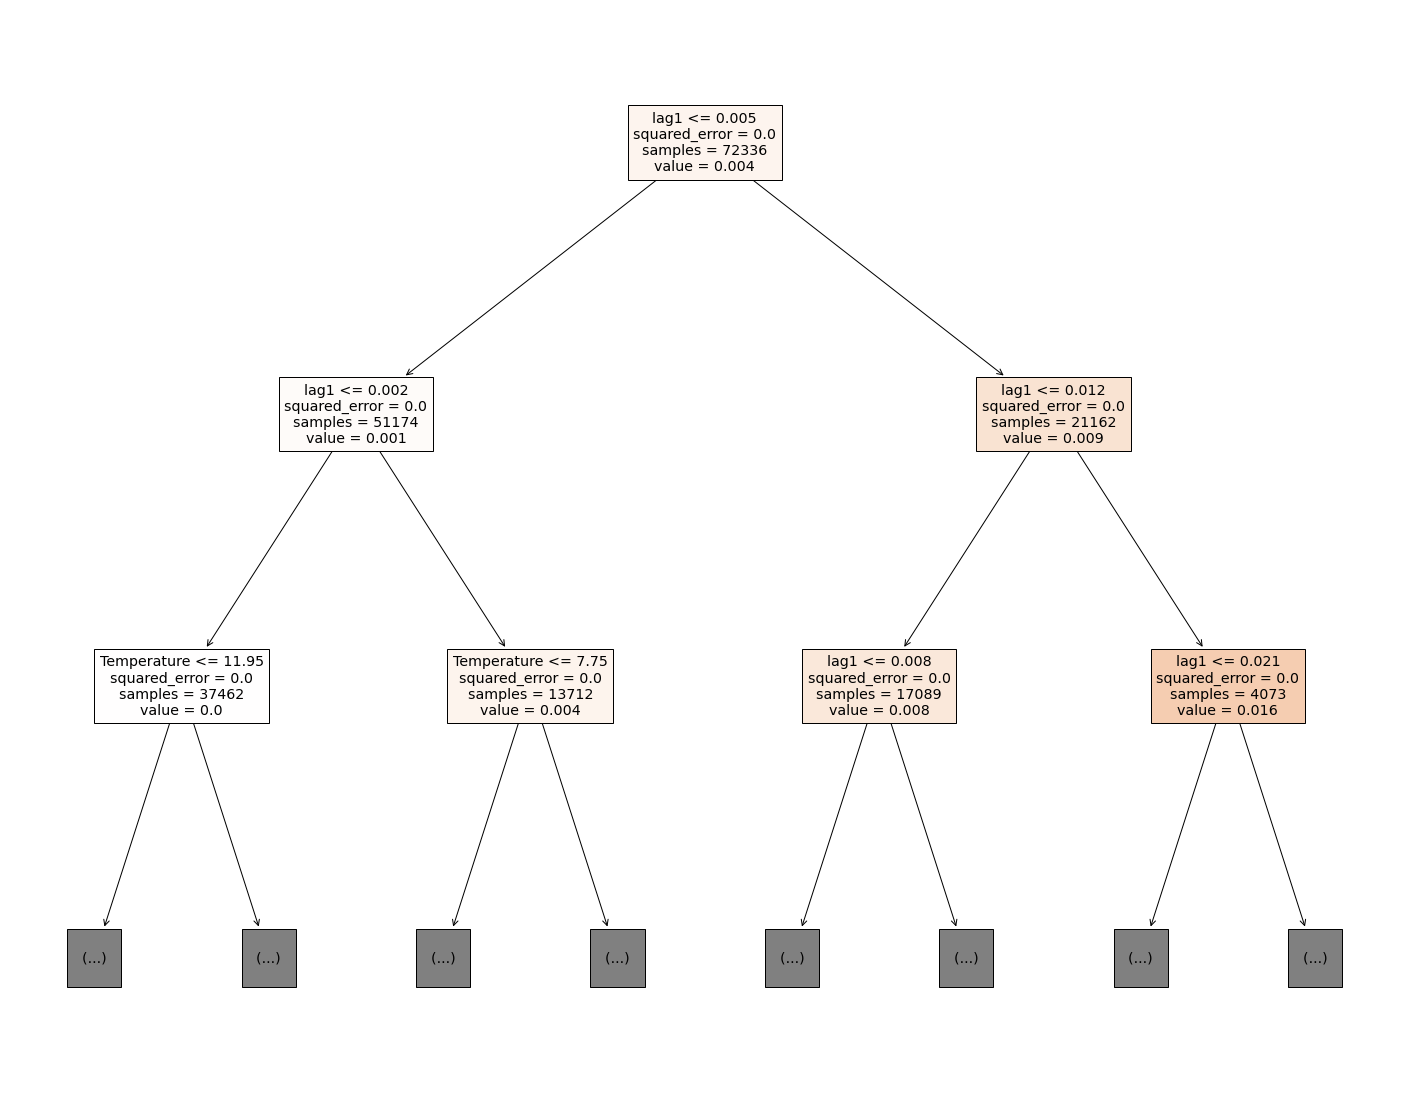

In [ ]:
import graphviz
from sklearn.tree import export_graphviz
from sklearn import tree

for model in pipe_dt:
  fig = plt.figure(figsize=(25,20))
  _ = tree.plot_tree(model,max_depth=2, feature_names=X_train.columns,filled=True)
